In [ ]:
%pip install --quiet ucimlrepo sentence_transformers umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
# imstall packages
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import umap
import sklearn

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# import data
df = pd.read_csv("/BP_3511.1_cleaned.csv")

## Keyword Indicator Analysis

In [ ]:
# load model
emdedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# create function
def get_embedding(text):
  """
  Get embeddings for a string, if the input is not a string, return a zero vector
  """
  if not isinstance(text, str):
    return np.zeros(384)
  else:
    return emdedding_model.encode(text)

# apply function
df["embedding"] = df["BP3511.1: PDF Text"].apply(get_embedding)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# define indicator keywords
keywords = {
    "zero_waste": ["zero waste schools", "waste reducation initiatives", "school district recycling programs"],
    "water_conservation": ["water conservation in schools", "school district water-saving", "water efficiency educational institutions"],
    "school_gardens": ["school garden projects", "edible gardens in schools", "educational gardens school district", "interactive gardens", "native gardens"],
}

# define function
def get_similarity(embedding, keywords):
  """
  Get the cosine similarity between an embedding and a list of keywords/pharses
  """
  keyword_embeddings = [get_embedding(keyword) for keyword in keywords]
  similarities = [cosine_similarity(embedding.reshape(1, -1), keyword_embedding.reshape(1, -1))[0][0] for keyword_embedding in keyword_embeddings]
  return np.mean(similarities)

# apply similarity calculation for each indicator
for indicator, keywords in keywords.items():
  df[f"{indicator}_similarity"] = df['embedding'].apply(lambda x: get_similarity(x, keywords))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 45 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Unnamed: 0                                                                       512 non-null    int64  
 1   CDS Code                                                                         512 non-null    int64  
 2   County                                                                           512 non-null    object 
 3   District Name                                                                    512 non-null    object 
 4   Locale Classifications                                                           512 non-null    object 
 5   District Type                                                                    512 non-null    object 
 6   2023-24 St

### Preprocess Data for Regression Analysis

In [ ]:
# subset data for analysis
reg_df = df[['BP 3511.1 Year Adopted', 'District Type', 'zero_waste_similarity',
             'Zero Waste Initiative', '2023-24 Student Enrollment', 'school_gardens_similarity',
             'water_conservation_similarity', 'Water Conservation', 'School Gardens']].copy()

# rename columns
reg_df.rename({'BP 3511.1 Year Adopted': 'year_adopted',
                'District Type': 'district_type',
                'Water Conservation': 'water_conservation_indicator',
                '2023-24 Student Enrollment': 'student_enrollment',
                'School Gardens': 'school_gardens_indicator',
                'Zero Waste Initiative': 'zero_waste_indicator'},
               axis=1, inplace=True)


# encode categorical columns
categorical_columns = ['district_type']
reg_df = pd.get_dummies(reg_df, columns=categorical_columns, drop_first=True, dtype=int)

### Water Conservation Indicator Regression Analysis

                                 OLS Regression Results                                 
Dep. Variable:     water_conservation_indicator   R-squared:                       0.014
Model:                                      OLS   Adj. R-squared:                  0.007
Method:                           Least Squares   F-statistic:                     1.859
Date:                          Thu, 16 Jan 2025   Prob (F-statistic):              0.116
Time:                                  00:32:43   Log-Likelihood:                -318.72
No. Observations:                           512   AIC:                             647.4
Df Residuals:                               507   BIC:                             668.6
Df Model:                                     4                                         
Covariance Type:                      nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----

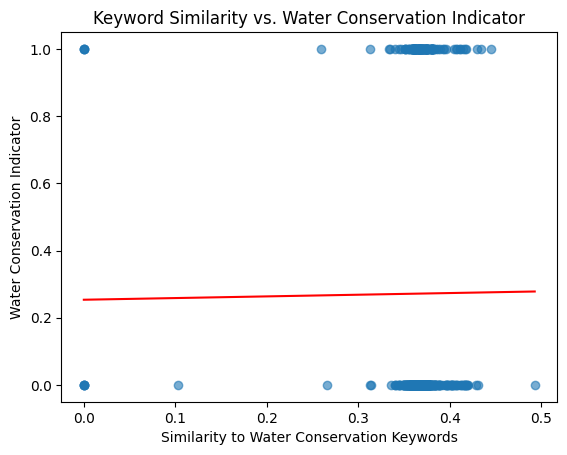

In [ ]:
# more renaming
reg_df.rename({'district_type_High School District': 'district_type_High_School_District',
                'district_type_Unified School District': 'district_type_Unified_School_District'},
               axis=1, inplace=True)

# fit model
model_ols_WC = smf.ols('water_conservation_indicator~water_conservation_similarity + student_enrollment + district_type_High_School_District + district_type_Unified_School_District', data=reg_df).fit()
print(model_ols_WC.summary())

# Plot scatter plot: cosine similarty (x-axis) vs. sustainability score
plt.scatter(reg_df['water_conservation_similarity'], reg_df['water_conservation_indicator'], alpha=0.6)
# Generate values for the line of best fit
x = np.linspace(reg_df['water_conservation_similarity'].min(), reg_df['water_conservation_similarity'].max(), 100)  # Range of the predictor
y = model_ols_WC.params['Intercept'] + model_ols_WC.params['water_conservation_similarity'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel('Similarity to Water Conservation Keywords')
plt.ylabel('Water Conservation Indicator')
plt.title('Keyword Similarity vs. Water Conservation Indicator')
plt.show()

### Zero Waste Indicator Regression Analysis

                             OLS Regression Results                             
Dep. Variable:     zero_waste_indicator   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                 -0.002
Method:                   Least Squares   F-statistic:                    0.7871
Date:                  Thu, 16 Jan 2025   Prob (F-statistic):              0.534
Time:                          00:37:05   Log-Likelihood:                -279.05
No. Observations:                   512   AIC:                             568.1
Df Residuals:                       507   BIC:                             589.3
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

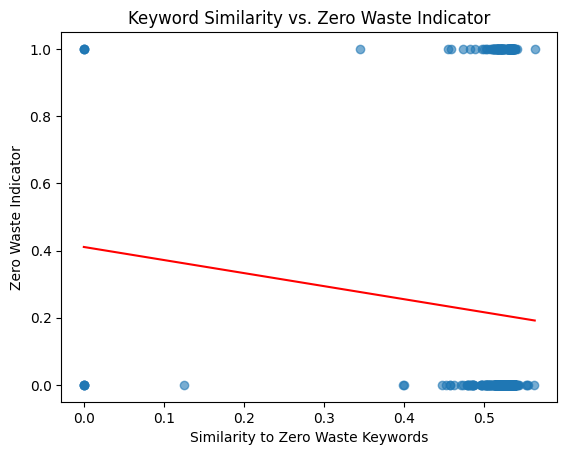

In [ ]:
# fit model
model_ols_ZW = smf.ols('zero_waste_indicator~zero_waste_similarity + student_enrollment + district_type_High_School_District + district_type_Unified_School_District', data=reg_df).fit()
print(model_ols_ZW.summary())

# Plot scatter plot: cosine similarty (x-axis) vs. sustainability score
plt.scatter(reg_df['zero_waste_similarity'], reg_df['zero_waste_indicator'], alpha=0.6)
# Generate values for the line of best fit
x = np.linspace(reg_df['zero_waste_similarity'].min(), reg_df['zero_waste_similarity'].max(), 100)  # Range of the predictor
y = model_ols_ZW.params['Intercept'] + model_ols_ZW.params['zero_waste_similarity'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel('Similarity to Zero Waste Keywords')
plt.ylabel('Zero Waste Indicator')
plt.title('Keyword Similarity vs. Zero Waste Indicator')
plt.show()

### School Garden Indicator Regression Analysis

                               OLS Regression Results                               
Dep. Variable:     school_gardens_indicator   R-squared:                       0.013
Model:                                  OLS   Adj. R-squared:                  0.005
Method:                       Least Squares   F-statistic:                     1.640
Date:                      Thu, 16 Jan 2025   Prob (F-statistic):              0.163
Time:                              00:42:57   Log-Likelihood:                -367.31
No. Observations:                       512   AIC:                             744.6
Df Residuals:                           507   BIC:                             765.8
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

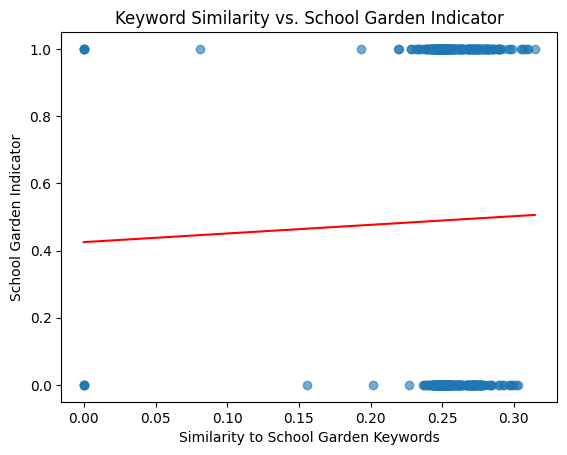

In [ ]:
# fit model
model_ols_SG = smf.ols('school_gardens_indicator~school_gardens_similarity + student_enrollment + district_type_High_School_District + district_type_Unified_School_District', data=reg_df).fit()
print(model_ols_SG.summary())

# Plot scatter plot: cosine similarty (x-axis) vs. sustainability score
plt.scatter(reg_df['school_gardens_similarity'], reg_df['school_gardens_indicator'], alpha=0.6)
# Generate values for the line of best fit
x = np.linspace(reg_df['school_gardens_similarity'].min(), reg_df['school_gardens_similarity'].max(), 100)  # Range of the predictor
y = model_ols_SG.params['Intercept'] + model_ols_SG.params['school_gardens_similarity'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel('Similarity to School Garden Keywords')
plt.ylabel('School Garden Indicator')
plt.title('Keyword Similarity vs. School Garden Indicator')
plt.show()

## Mild/Medium/Spciy Language Analysis

In [ ]:
# create copy of df
lang_df_1 = df.copy()

# create dictionary for mild/medium/spicy language
language_dict = {
    "mild_1": "The Governing Board believes that the conservation of natural resources and the protection of the environment are connected to the district's educational mission and are essential to the health and well-being of the community.",
    "medium_1": "The Governing Board believes that the conservation of natural resources, the protection of the environment, and the reduction of harm to the climate are connected to the district's educational mission and are essential to the health and well-being of the community.",
    "spicy_1": "The Governing Board believes that the conservation of natural resources, the protection of the environment, the reduction of harm to the climate, and the enhanced stewardship of the surrounding land are connected to the district's educational mission and are essential to the health and well-being of the community.",
    "mild_2": "The Superintendent or designee shall develop and/or implement a cost-effective, integrated waste management program that incorporates the principles of green school operations.",
    "medium_2": "The Superintendent or designee shall develop and implement a cost-effective, integrated waste management program that incorporates and promotes the principles of green school operations.",
    "spicy_2": "The Superintendent or designee shall spearhead the development and implementation of a comprehensive waste management program, ensuring not only cost-effectiveness but setting district-wide standards in green school operations. This program shall prioritize zero-waste initiatives, community engagement, and continuous improvement through annual sustainability reviews.",
    "mild_3": "To the extent that funding permits, the Superintendent or designee shall provide appropriate educational and training opportunities to students and staff regarding the benefits and methods of conserving natural resources and protecting the environment.",
    "medium_3": "The Superintendent or designee shall provide appropriate educational and training opportunities to students and staff regarding the benefits and methods of conserving natural resources and protecting the environment. These educational and training opportunities include, but are not limited to: Incorporating lessons about conservation and environmental protection into existing or new curriculum, Place-based or environmental learning, Providing extracurricular activities and/or incentives aimed at fostering values of conservation and environmental protection",
    "spicy_3": "The Superintendent or designee shall be at the forefront of launching innovative educational and training initiatives for students and staff, centered on the critical nature of conserving natural resources and championing environmental protection. These expansive initiatives shall: Integrating lessons about conservation and environmental protection into every grade level and subject curriculum, Prioritize immersive, place-based, and environmental learning experiences that connect students with their local ecosystems, Develop a wide array of extracurricular activities, clubs, and incentive programs dedicated to nurturing a generation of environmental stewards and changemakers",
    "mild_4": "The Superintendent or designee may collaborate with city, county, and state agencies and other public or private agencies in developing and implementing the district's integrated waste management program.",
    "medium_4": "The Superintendent or designee will collaborate with city, county, and state agencies and other public or private agencies in developing and implementing the district's integrated waste management program. If funding permits, the Superintendent or designee will create a district position or direct a group to explore CalRecycle’s resources and manage collaborations.",
    "spicy_4": "The Superintendent or designee shall proactively foster and establish dynamic partnerships with city, county, state agencies, and other public or private entities. This dedication to collaboration will not only encompass the development and refinement of the district's integrated waste management program but also other sustainability initiatives. A dedicated district position will be established, with or without external funding, to tap into vast resources such as CalRecycle and to champion these collaborative efforts, ensuring maximum community impact and sustainability leadership."
}

# clean text
def clean_pdf_text(text):
    """
    Cleans up textual data by lowercasing all letters, removing punctuation, removing stop words,
    and lemmatizing.
    """
    text = re.sub(r'Education code.*$', '', text, flags=re.IGNORECASE)
    text = re.sub(r'legal reference.*', '', text, flags=re.IGNORECASE | re.DOTALL) # Use regex to remove 'legal reference' and everything after
    text = text.lower() # Lowercase text
    tokens = word_tokenize(text) # Tokenize text
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens if re.sub(r'[^\w\s]', '', token)] # Regular expression to match punctuation
    stop_words = set(stopwords.words('english')) # Define stop words
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmetize
    cleaned_text = ' '.join(tokens) # Join tokens back into a string

    return cleaned_text

# apply function
language_dict = dict((temperature, clean_pdf_text(language)) for temperature, language in language_dict.items())

# apply similarity function
for temperature, language in language_dict.items():
    lang_df_1[f"{temperature}_similarity"] = lang_df_1['embedding'].apply(lambda x: get_similarity(x, [language]))

### Scoville Scale Language Menu Regression

In [ ]:
lang_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 57 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Unnamed: 0                                                                       512 non-null    int64  
 1   CDS Code                                                                         512 non-null    int64  
 2   County                                                                           512 non-null    object 
 3   District Name                                                                    512 non-null    object 
 4   Locale Classifications                                                           512 non-null    object 
 5   District Type                                                                    512 non-null    object 
 6   2023-24 St

                             OLS Regression Results                             
Dep. Variable:     sustainability_score   R-squared:                       0.031
Model:                              OLS   Adj. R-squared:                  0.008
Method:                   Least Squares   F-statistic:                     1.349
Date:                  Thu, 16 Jan 2025   Prob (F-statistic):              0.187
Time:                          01:10:32   Log-Likelihood:                -744.02
No. Observations:                   512   AIC:                             1514.
Df Residuals:                       499   BIC:                             1569.
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

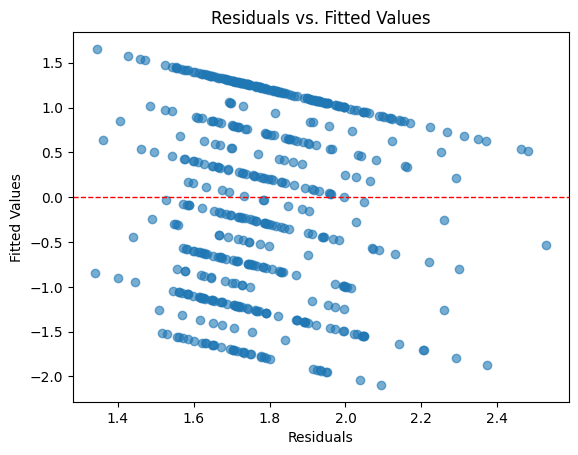

In [ ]:
lang_df_1 = lang_df_1.rename({"District Name": "district_name",
                  "District-Wide Campus Sustainability Indicators (up to 3)": "sustainability_score"},
                             axis=1)
# ols model
model_ols_language = smf.ols("sustainability_score ~ mild_1_similarity + medium_1_similarity + spicy_1_similarity + mild_2_similarity + medium_2_similarity + spicy_2_similarity + mild_3_similarity + medium_3_similarity + spicy_3_similarity + mild_4_similarity + medium_4_similarity + spicy_4_similarity", data=lang_df_1).fit()
print(model_ols_language.summary())

# Plot residuals
plt.scatter(model_ols_language.fittedvalues, model_ols_language.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

## Clustering Analysis

In [ ]:
# create a dataframe from the embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

df_copy = df.copy()
df_copy = df_copy.dropna(subset=['BP3511.1: PDF Text'])

# subset column and drop null values
bp = df_copy['BP3511.1: PDF Text'].tolist()

# Use `embedding_model` to create an embedding for each text
bp_embeddings = pd.DataFrame(embedding_model.encode(bp, random_state=211))
bp_embeddings = bp_embeddings.rename(lambda x: f"embedding_dim_{x}", axis=1)
bp_embeddings = bp_embeddings.assign(district = df_copy['District Name'].tolist())
bp_embeddings = bp_embeddings.assign(score = df_copy['District-Wide Campus Sustainability Indicators (up to 3)'].tolist())
bp_embeddings

,embedding_dim_0,embedding_dim_1,embedding_dim_2,embedding_dim_3,embedding_dim_4,embedding_dim_5,embedding_dim_6,embedding_dim_7,embedding_dim_8,embedding_dim_9,...,embedding_dim_376,embedding_dim_377,embedding_dim_378,embedding_dim_379,embedding_dim_380,embedding_dim_381,embedding_dim_382,embedding_dim_383,district,score
0,0.068580,-0.000617,0.051867,-0.013987,-0.001920,-0.013026,-0.019603,-0.030714,-0.128025,0.010207,...,-0.005271,0.001996,0.018669,0.008528,0.114943,0.016118,-0.011704,0.002033,Alameda Unified,3.00
1,0.066679,-0.002194,0.055982,-0.013081,-0.000440,-0.016995,-0.016437,-0.031356,-0.129372,0.011096,...,-0.009171,0.001851,0.020312,0.008213,0.110336,0.010409,-0.013084,0.001392,Albany City Unified,3.00
2,0.058745,0.005221,0.016306,0.001615,0.011926,-0.007688,-0.023077,-0.021620,-0.120235,0.012563,...,-0.024465,0.004523,0.018713,0.011993,0.101889,0.024597,-0.020543,-0.002229,Castro Valley Unified,3.00
3,0.026282,0.037165,0.056439,-0.028188,0.023045,-0.005025,0.003327,-0.056069,-0.144741,0.008703,...,-0.007499,-0.014148,-0.013965,-0.004491,0.104470,-0.007936,-0.009367,0.014508,Emery Unified,2.50
4,0.058491,0.011034,0.056771,-0.015585,0.007407,-0.000649,-0.024336,-0.034642,-0.122913,0.015051,...,-0.003485,0.002023,0.014560,0.002438,0.104868,0.004016,-0.009246,-0.000219,Hayward Unified,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,0.060251,0.006695,0.032773,0.026341,0.019991,0.000217,-0.025894,-0.034679,-0.108598,0.016170,...,-0.020856,0.011161,0.018491,0.017198,0.108190,0.025130,-0.010862,0.014580,Washington Unified,1.50
499,0.057004,0.011906,0.023021,0.008248,0.023080,-0.005865,-0.040123,-0.085283,-0.077587,0.017152,...,-0.047302,-0.012230,0.008377,-0.043084,0.099475,-0.028204,-0.071696,-0.018544,Woodland Joint Unified,1.00
500,0.062930,0.007733,0.060897,-0.005586,0.012669,0.006578,-0.022956,-0.041563,-0.096599,0.011714,...,-0.023561,-0.025129,0.022453,0.025821,0.101406,0.000059,0.001926,0.001470,Marysville Joint Unified,1.50
501,0.063058,-0.004696,0.053747,-0.017859,0.000642,-0.015281,-0.016673,-0.029123,-0.128624,0.013685,...,0.001053,-0.000762,0.014864,0.009338,0.118437,0.017272,-0.012008,0.001832,Plumas Lake Elementary,0.50


In [ ]:
# Initialize the umap reducer object
reducer = umap.UMAP(n_components=2)
embedding_columns = [c for c in bp_embeddings.columns if c not in ('district', 'score')]

# Fit the reducer
reducer.fit(bp_embeddings[embedding_columns])

# Transform the embeddings
embeddings_2dim_df = pd.DataFrame(reducer.transform(bp_embeddings[embedding_columns]))
embeddings_2dim_df['district'] = bp_embeddings['district']
embeddings_2dim_df['score'] = bp_embeddings['score']
embeddings_2dim_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1,district,score
0,7.875920,0.770371,Alameda Unified,3.00
1,8.355120,1.058201,Albany City Unified,3.00
2,13.907313,-0.665279,Castro Valley Unified,3.00
3,-9.702349,-1.775076,Emery Unified,2.50
4,10.644455,22.584332,Hayward Unified,3.00
...,...,...,...,...
498,14.738772,-1.311766,Washington Unified,1.50
499,14.237418,-1.143487,Woodland Joint Unified,1.00
500,9.563292,1.198995,Marysville Joint Unified,1.50
501,8.078837,1.828384,Plumas Lake Elementary,0.50


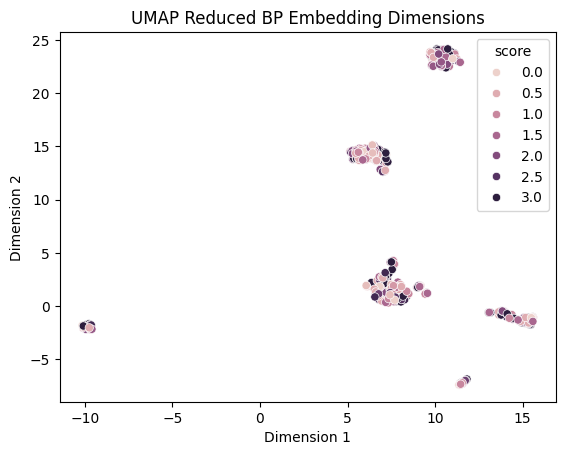

In [ ]:
# plot the umap reduced embedding dimensions; set hue to sustainability score
ax = sns.scatterplot(embeddings_2dim_df, x=0, y=1, hue='score')
plt.title('UMAP Reduced BP Embedding Dimensions')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
sns.set_theme(rc={'figure.figsize':(10, 6)})

## Looking at School Scale

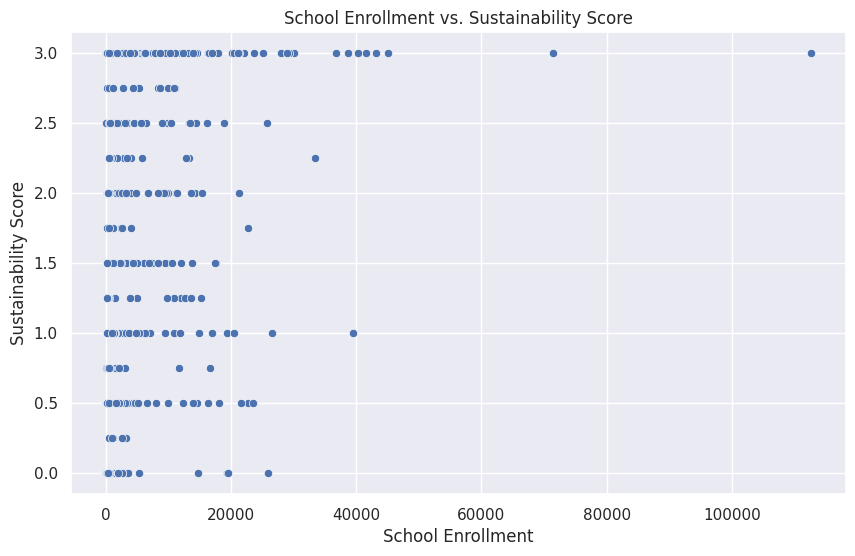

In [ ]:
df_scale = df.copy()
df_scale = df_scale.dropna(subset=['BP3511.1: PDF Text'])


# plot school enrollment against sustainability score
ax = sns.scatterplot(df_scale, x='2023-24 Student Enrollment', y='District-Wide Campus Sustainability Indicators (up to 3)')
plt.title('School Enrollment vs. Sustainability Score')
plt.xlabel('School Enrollment')
plt.ylabel('Sustainability Score')
sns.set_theme(rc={'figure.figsize':(10, 6)})